# SageMaker GroundTruth Custom Labeling Workflow
---

---

## Contents

1. [Introduction](#Introduction)
2. [Solution-overview](#Solution-overview)
3. [Prerequisites](#Prerequisites)
4. [Set-up-the-environment](#Set-up-the-environment)
5. [Run-a-Ground-Truth-labeling-job](#Run-a-Ground-Truth-labeling-job)
    1. [Prepare-the-data](#Prepare-the-data)
        1. [Upload the dataset to Amazon S3](#Upload-images-to-S3-bucket)
        2. [Prepare-labeling-input-manifest-file](#Prepare-labeling-input-manifest-file)
    2. [Create-the-instruction-template](#Create-the-instruction-template)
    3. [Define-pre-built-lambda-functions-for-use-in-the-labeling-job](#Define-pre-built-lambda-functions-for-use-in-the-labeling-job)
    
    
6. [Submit-the-Ground-Truth-job-request](#Submit-the-Ground-Truth-job-request)

7. [Monitor-job-progress](#Monitor-job-progress)
8. [View-task-results](#View-task-results)

# Introduction

In this notebook, we guides you through the process of setting up a workflow with a custom labeling template

Amazon SageMaker Ground Truth provides labeling workflows for humans to work on image and text classification, object detection, and semantic segmentation labeling jobs. You can also build custom workflows to define the user interface (UI) for data labeling jobs. 

To help you get started, Amazon SageMaker provides custom templates for image, text, and audio data labeling jobs. These templates use the Amazon SageMaker Ground Truth crowd HTML elements, which simplify building data labeling UIs. You can also specify your own HTML for the UI.

You might want to build a custom workflow for the following reasons:

* You have custom data labeling requirements.
* Your input data is complex, with multiple elements (for example, images, text, or custom metadata) per task.
* You want to prevent sending certain items to labelers when you create tasks.
* You require custom logic to consolidate labeling output and improve accuracy.


# Solution-overview

To build a custom workflow, We will used the sample images stored in the data folder.

To extract text from the data, We used the Amazon Textract SDK and stored the output(in .csv) in the data fodler

To build the custom UI, We use the React framework and build the static files under web folder.

We uses server-side AWS Lambda functions for pre-labeling and post-labeling processing. The following diagram shows the high-level workflow. 

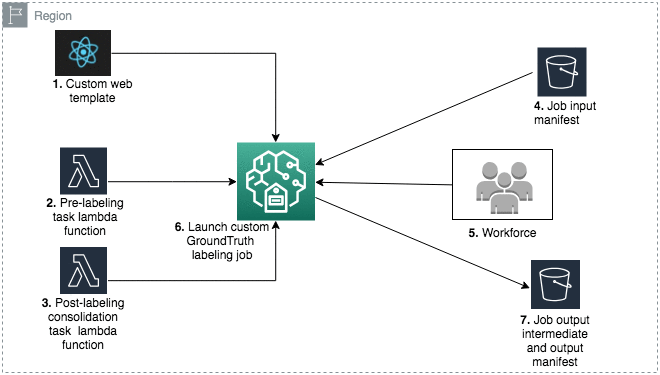

You can create a custom labeling job using the Ground Truth section of the [Amazon SageMaker console](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-create-labeling-job-console.html) or the [CreateLabelingJob operation.](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-create-labeling-job-api.html)

You can select your **workforce** from one of three providers:

* A private workforce that you create. It can include employees, contractors, and outside experts. Use a private workforce when want the data to stay within your organization or when a specific set of skills is required.

* One or more vendors that you select from the AWS Marketplace. Vendors provide expertise in specific areas.

* The Amazon Mechanical Turk workforce. This is the largest workforce, but it should only be used for public data or data that has been stripped of any personally identifiable information.

Information required for human workers to complete a labeling task([**HumanTaskConfig**](https://docs.aws.amazon.com/sagemaker/latest/APIReference/API_HumanTaskConfig.html)).

* The pre-processing Lambda function helps customize input to the HTML interface.

* The post-processing Lambda function helps to process the data. For example, one of its primary uses is to host an accuracy improvement algorithm to tell Ground Truth how it should assess the quality of human-provided labels.

* Custom template - To build the labeling UI that displays a .jpg image, text for annotation, a free-form text field for additional notes, and a yes/no element to classify the quality of the abstract, you create a single-page Web app using React. The static JavaScript and CSS files are hosted on Amazon S3 at s3://S3Bucket/web/static. If you are curious about how I built the web app, refer to the [GitHub repository](https://github.com/nitinaws/gt-custom-workflow/tree/master/web) and this [AWS Blog](https://aws.amazon.com/blogs/machine-learning/build-a-custom-data-labeling-workflow-with-amazon-sagemaker-ground-truth/) for instructions.

With this app, a worker performing labeling can annotate the abstracts by labeling selected text. The worker can choose the type of entity (Background, Objectives, Methods, Results, Conclusions, and Limitations) from a dropdown list, as shown in the following screenshot. The worker can also add notes and label the quality of the abstract.


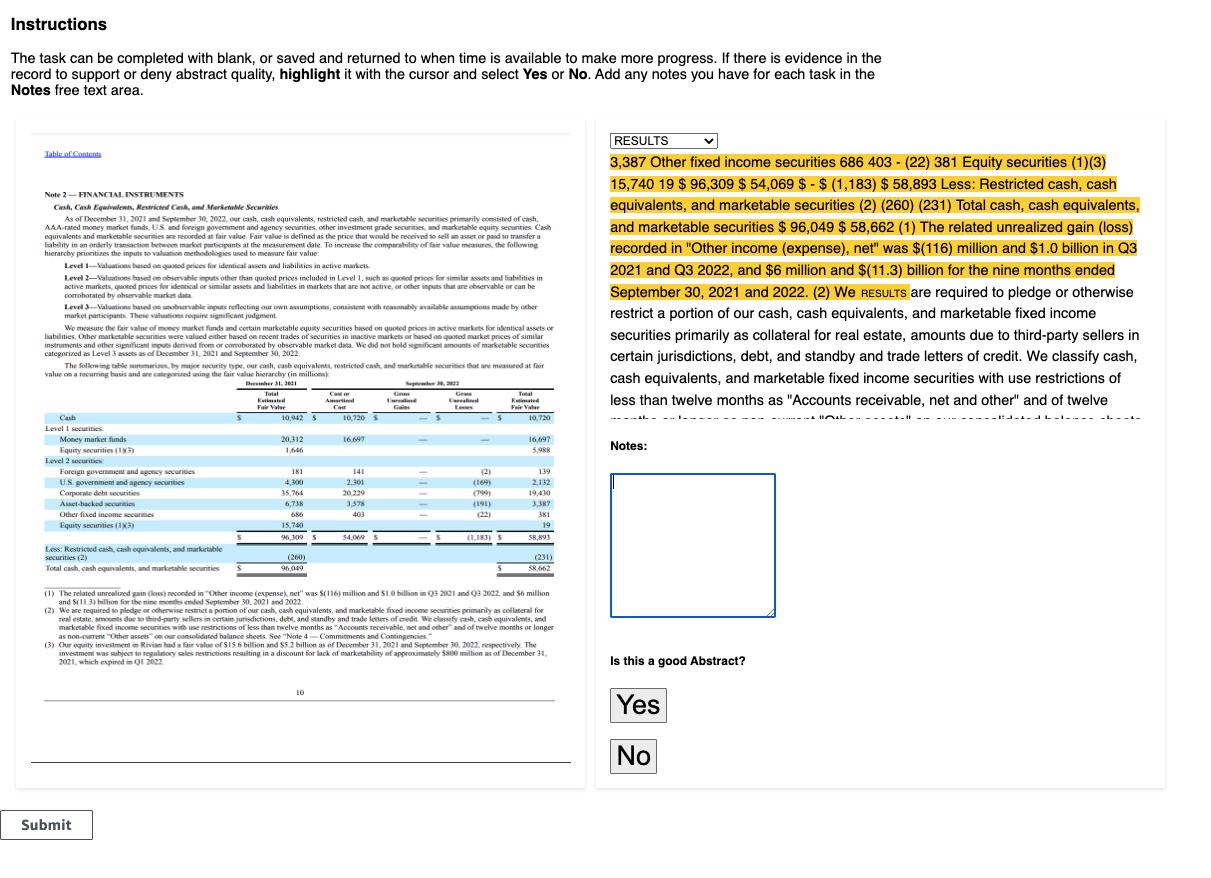

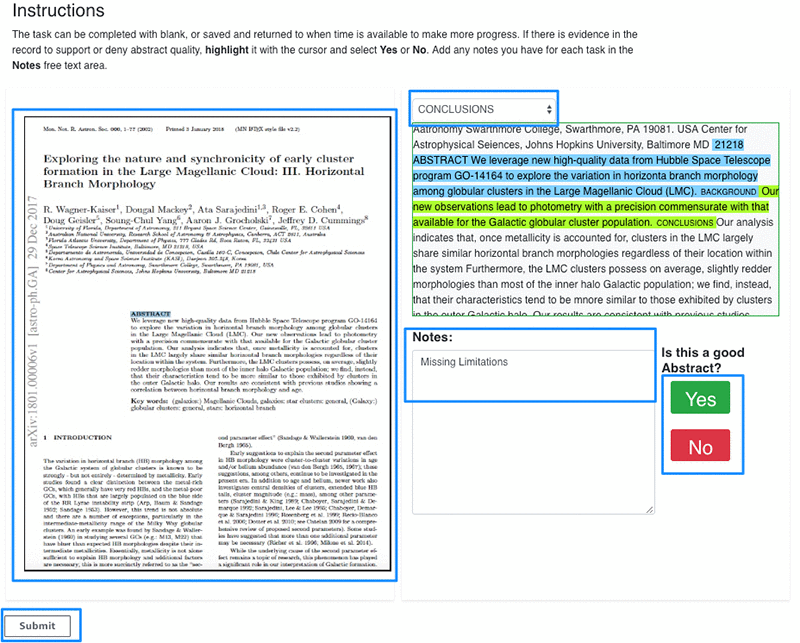

# Set-up-the-environment

Execute the contents of cell 01 and 02 (click on the cell and then key Shift+Enter to execute). Please note, there will be no output and it will execute immediately

In [ ]:
# cell 01
import json
import sagemaker
import boto3
import uuid
import time
import os
import glob 
from urllib.parse import urlparse
import pandas as pd

In [ ]:
# cell 02

role = sagemaker.get_execution_role()
region = boto3.session.Session().region_name

s3 = boto3.client("s3")

BUCKET=sagemaker.Session().default_bucket()
BUCKET_PREFIX = "creating-custom-labeling-workflow"

# Run-a-Ground-Truth-labeling-job
**This section should take about 30Min to complete.**

We will first run a labeling job. This involves several steps: collecting the reviews text we want labeled, specifying the possible label categories, creating instructions, and writing a labeling job specification. In addition, we highly recommend to run a (free) mock job using a private workforce before you submit any job to the public workforce. This notebook will explain how to do that as an optional step. Without using a private workforce, this section until completion of your labeling job should take about 30Min. However, this may vary depending on the availability of the public annotation workforce.

## Prepare-the-data

### Upload-images-to-S3-bucket

This step reads all of the files in the data folder and uploads them to the S3 bucket.


In [ ]:
# cell 03
# S3 content of data directory and upload it including manifest file
EXP_NAME = "data"  # Any valid S3 prefix.
data_path = "data/*"
for img in glob.glob(data_path):
    file_name = os.path.basename(img)
    s3.upload_file(img, BUCKET, BUCKET_PREFIX + '/' +  EXP_NAME + '/' + file_name)
print("-- upload complete --")

### Prepare-labeling-input-manifest-file
SageMaker Ground Truth operates using manifests. When using a modality like image classification, a single image corresponds to a single entry in a manifest and a given manifest will directly contain paths for all of the images to be labeled. To learn how to create an input manifest file, see [Use an Input Manifest File](https://docs.aws.amazon.com/sagemaker/latest/dg/sms-input-data-input-manifest.html). 


In [ ]:
# cell 04

def parse_response(response):
    list=[]
    prefix = ''
    for content in response['Contents']:
        if (content['Size'] > 0):
            print(content['Key'])
            file_name = content['Key']
            list.append(file_name)

    return list

image_url = urlparse("s3://"+BUCKET+"/"+BUCKET_PREFIX+"/data")

image_response = s3.list_objects(Bucket=image_url.netloc, Prefix=image_url.path[1:])

image_list = parse_response(image_response)

content_list = []

for item in image_list:
    print(item)
    image_filename = item.split('/')[-1]
    text_filename = "{}.csv".format(image_filename)
    entry = {}
    if "{}/{}".format(image_url.path[1:],text_filename) in image_list:
        print("Adding new Entry")
        print(image_url.netloc)
        entry["source-ref"] = 's3://{}/{}/{}/{}'.format(image_url.netloc,BUCKET_PREFIX,EXP_NAME,image_filename)
        entry["text-file-s3-uri"] = 's3://{}/{}/{}/{}'.format(image_url.netloc,BUCKET_PREFIX,EXP_NAME,text_filename)
        content_list.append(json.dumps(entry))

content = "".join(str("{}\n".format(line)) for line in content_list)
print(content)

body = bytes(content,'utf-8')

resp = s3.put_object(Bucket=image_url.netloc, Key="{}/manifest.json".format(image_url.path[1:]), Body=body)
print(resp)

### Create-the-instruction-template
Part or all of your reviews will be annotated by human annotators. It is **essential** to provide good instructions that help the annotators give you the annotations you want. Good instructions are:
* Upload the static JavaScript and CSS files from web folder
* Update the below html template to provide the cloud front path to css file
* Update the below html template to provide the cloud front path to js file

In [ ]:
# cell 05
# S3 content of static JavaScript and CSS files and upload
static_assests_path = "web/"
for path, dirs, files in os.walk(static_assests_path):
    for file in files:
        file_s3 = os.path.normpath(path + '/' + file)
        file_name = os.path.basename(file)
        s3.upload_file(os.path.join(path,file), BUCKET, BUCKET_PREFIX + '/' +file_s3)
print("-- upload complete --")

In [ ]:
# cell 06
# a template for custom labeling 
# Update the below html template to provide the cloud front path to css file (cloudfront domain name/web/static/css/main.a9619231.css )
# Update the below html template to provide the cloud front path to js file (cloudfront domain name/web/static/js/main.059ee2ed.js)
def make_template(test_template=False, save_fname="instructions.template"):
    template = r"""<script src="https://assets.crowd.aws/crowd-html-elements.js"></script>
    <!-- Replace href path with the css path below <https://cloudfront domain name/creating-custom-labeling-workflow/web/static/css/main.a9619231.css>-->
      <link rel="stylesheet" href="<update here to provide css path>">
        <div id='document-text' style="display: none;">
        {{ task.input.text }}
        </div>
        <div id='document-image' style="display: none;">
        {{ task.input.taskObject | grant_read_access }}
        </div>
        <div id="metadata" style="display: none;">
        {{ task.input.metadata }}
        </div>
        <!-- Custom annotation user interface is rendered here -->
        <div id="root"></div>
            <crowd-button id="submitButton">Submit</crowd-button>
            <script>
                document.querySelector('crowd-form').onsubmit = function() {
                    document.getElementById('annotations').value = JSON.stringify(JSON.parse(document.querySelector('pre').innerText));
                };
                document.getElementById('submitButton').onclick = function() {
                document.querySelector('crowd-form').submit();
                };
            </script>
         <!-- Replace href path with the js path below   <https://cloudfront domain name/creating-custom-labeling-workflow/web/static/js/main.059ee2ed.js> -->
        <script src="<update here to provide js path>"></script>
       
        <crowd-form>
            <input name="annotations" id="annotations" type="hidden">
            <!-- Prevent crowd-form from creating its own button -->
            <crowd-button form-action="submit" style="display: none;"></crowd-button>
        </crowd-form>
       
"""
    
          
    with open(save_fname, "w") as f:
        f.write(template)
    if test_template is False:
        print(template)


#make_template(test_template=True, save_fname="instructions.html")
make_template(test_template=False, save_fname="template.html")
s3.upload_file("template.html", BUCKET, BUCKET_PREFIX+ "/web/input/template.html")

In [ ]:
# cell 07
# choose the workforce team
private_workteam_arn = "<< your private workteam ARN here >>"

WORKTEAM_ARN = private_workteam_arn


print("WORKTEAM_ARN : {}".format(WORKTEAM_ARN))

### Define-pre-built-lambda-functions-for-use-in-the-labeling-job 

Before we submit the request, we need to define the ARNs for 3 key components of the labeling job: 1) the workteam, 2) the annotation consolidation Lambda function, 3) the pre-labeling task Lambda function. These functions are defined by strings with region names and AWS service account numbers, so we will define a mapping below that will enable you to run this notebook in any of our supported regions.

In [ ]:
# cell 08
# Specify ARNs for resources needed to run an custom-labeling job
# Get the ARN from the Cloudformation template

#Pre annotation Lambda ARN

prehuman_arn = "<< your private workteam ARN here >>"

#Post annotation Lambda ARN

posthuman_arn = "<< your private workteam ARN here >>"

# Submit-the-Ground-Truth-job-request
The API starts a Ground Truth job by submitting a request. The request contains the 
full configuration of the annotation task, and allows you to modify the fine details of
the job that are fixed to default values when you use the AWS Console. The parameters that make up the request are described in more detail in the [SageMaker Ground Truth documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/API_CreateLabelingJob.html).

After you submit the request, you should be able to see the job in your AWS Console, at `Amazon SageMaker > Labeling Jobs`.
You can track the progress of the job there. This job will take several hours to complete. If your job
is larger (say 10,000 review text), the speed and cost benefit of auto-labeling should be larger.

In [ ]:
# cell 09
# task definitions
task_description = 'Carefully read and classify this text using the categories provided.'
task_keywords = ['Custom Labeling Job']
task_title = 'Custom Image Labeling Job'
job_name = "ground-truth-labeling-job-" + str(int(time.time()))
USE_AUTO_LABELING = False

# define human task config
human_task_config={
        'PreHumanTaskLambdaArn': prehuman_arn,
        'TaskKeywords': task_keywords,
        'TaskTitle': task_title,
        'TaskDescription': task_description ,
        'NumberOfHumanWorkersPerDataObject': 1,  # number of  workers required to label each text.
        'TaskTimeLimitInSeconds': 300,  # Each text must be labeled within 5 minutes.
        'TaskAvailabilityLifetimeInSeconds': 21600,  # Your worteam has 6 hours to complete all pending tasks.
        'MaxConcurrentTaskCount': 100,   # 100 text sentences will be sent at a time to the workteam.
        'AnnotationConsolidationConfig': {
        'AnnotationConsolidationLambdaArn': posthuman_arn,
        },
        'UiConfig': {
            'UiTemplateS3Uri': "s3://{}/{}/web/input/template.html".format(BUCKET, BUCKET_PREFIX),
        },

    }
    


human_task_config["WorkteamArn"] = private_workteam_arn

ground_truth_request = {
    "InputConfig":{
        'DataSource': {
            'S3DataSource': {
                'ManifestS3Uri': "s3://{}/{}/{}".format(BUCKET,BUCKET_PREFIX, "data/manifest.json"),
            }
        },
        'DataAttributes': {
            'ContentClassifiers': [
                'FreeOfPersonallyIdentifiableInformation','FreeOfAdultContent',
            ]
        }
    },
    "OutputConfig":{
        'S3OutputPath': "s3://{}/{}/output/".format(BUCKET, BUCKET_PREFIX),
    },
    
    "HumanTaskConfig": human_task_config,
    "LabelingJobName": job_name,
    "RoleArn": role,
    "LabelAttributeName": "label",
    "Tags":[
        {
            'Key': 'text',
            'Value': 'custom_label'
        },
    ]


}


sagemaker_client = boto3.client("sagemaker")
sagemaker_client.create_labeling_job(**ground_truth_request)

In [ ]:
#Navigate to the private worker portal and do the tasks

# cell 10
workteamName = WORKTEAM_ARN[WORKTEAM_ARN.rfind('/') + 1:]
print("Navigate to the private worker portal and do the tasks. Make sure you've invited yourself to your workteam!")
print('https://' + sagemaker_client.describe_workteam(WorkteamName=workteamName)['Workteam']['SubDomain'])

# Monitor-job-progress
A Ground Truth job can take a few minutes to complete (if your dataset is larger than 1000 reviews, it can take much longer than that!). One way to monitor the job's progress is through AWS Console. In this notebook, we will use Ground Truth output files and Cloud Watch logs in order to monitor the progress. You can re-evaluate the next two cells repeatedly.

In [ ]:
# cell 11
# re-evaluate repeatedly. It sends a `describe_labelging_job` request which should tell you whether the job is completed or not. 
#If it is, then 'LabelingJobStatus' will be 'Completed'.
while sagemaker_client.describe_labeling_job(LabelingJobName=job_name)['LabelingJobStatus'] == 'InProgress':
    job_status = sagemaker_client.describe_labeling_job(LabelingJobName=job_name)['LabelingJobStatus']
    print('Labelling job : {}, status : {}'.format(job_name, job_status))
    time.sleep(30)
print('Labelling job : {}, status : {}'.format(job_name, sagemaker_client.describe_labeling_job(LabelingJobName=job_name)['LabelingJobStatus']))

#Wait For Workers to Complete Task!

# View-task-results  

Once work is completed, SagMaker GroundTruth stores results in your S3 bucket and sends a Cloudwatch event. Your results should be available in the S3 OUTPUT_PATH when all work is completed.


In [ ]:
# cell 12
# ouput path
S3_OUTPUT = boto3.client('sagemaker').describe_labeling_job(LabelingJobName=job_name)['OutputConfig']['S3OutputPath'] + job_name
print('S3 OUPUT_PATH : {}'.format(S3_OUTPUT))


In [ ]:
# cell 13
# Download human annotation data.
!aws s3 cp {S3_OUTPUT + '/manifests/output/output.manifest'} ./output.manifest #--recursive --quiet

#Download the output (in json format) into dataframe 

In [ ]:
# cell 14
data = []
with open('./output.manifest') as f:
    for line in f:
         data.append(json.loads(line))
pd.DataFrame(data)